"Can demographic and geographic information be used to predict offense rates and crime types in different Local Government Areas?"

In [38]:
# Code 需要 sort
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Code 2
# Load the LGA offenses dataset (Table 1)
offenses_df = pd.read_excel('data/LGA Offences.xlsx', sheet_name='Table 01')

# Load the communities dataset
communities_df = pd.read_csv('data/communities.csv')

# Display the first few rows of each dataset
offenses_df.head()


,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population"
0,2023,December,1 North West Metro,Banyule,8072,6256.318199
1,2023,December,1 North West Metro,Brimbank,17044,8666.589574
2,2023,December,1 North West Metro,Darebin,13715,8823.868581
3,2023,December,1 North West Metro,Hobsons Bay,5720,6143.155350
4,2023,December,1 North West Metro,Hume,18342,7030.782116


In [39]:
communities_df['Region'] = communities_df['LGA'].str.extract(r'^(.*?)(?:\s*\((.*?)\))?$')[1]
communities_df['LGA'] = communities_df['LGA'].str.extract(r'^(.*?)(?:\s*\((.*?)\))?$')[0]

communities_df[["LGA", "Region"]]

communities_df.head()


,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,Abbotsford (Suburb),C,4,C3,3km ENE of Melbourne,3082.440714,6.114670,4.264157,Yarra,Inner North West Primary Care Partnership,...,6.955606,5.179985,1396.274370,St Vincent's Hospital,4.571875,3.191000,323.83038328,23.192461,885.4447909200001,63.414814
1,Aberfeldie (Suburb),C,4,B2,8km NW of Melbourne,2426.665450,13.410363,9.881527,Moonee Valley,Inner North West Primary Care Partnership,...,10.540675,7.835355,865.262419,Royal Melbourne Hospital,10.681174,7.916626,177.40004939,20.502456,487.0564898400001,56.290032
2,Aireys Inlet - Fairhaven (Catchment),S,2,D4,108km SW of Melbourne,0.841522,127.057589,134.213743,Surf Coast,G21 Health and Wellbeing Pillar,...,79.950423,58.405921,50.832048,Geelong Hospital,79.950423,58.405921,14.44740341,28.421840,27.98233923,55.048616
3,Aireys Inlet - Fairhaven (Town),S,2,D4,105km SW of Melbourne,213.059443,97.404694,124.859887,Surf Coast,G21 Health and Wellbeing Pillar,...,50.297529,49.052066,155.717114,Geelong Hospital,50.297529,49.052066,44.25766899,28.421840,85.72011677,55.048616
4,Airport West (Catchment),C,4,B1,11km NNW of Melbourne,210.819042,13.850488,14.758418,Moonee Valley,Inner North West Primary Care Partnership,...,9.705913,10.312795,222.247062,Royal Melbourne Hospital,11.121299,12.793518,39.80414965,17.909865,113.66007,51.141315


0        Banyule
1       Brimbank
2        Darebin
3    Hobsons Bay
4           Hume
Name: Local Government Area, dtype: object


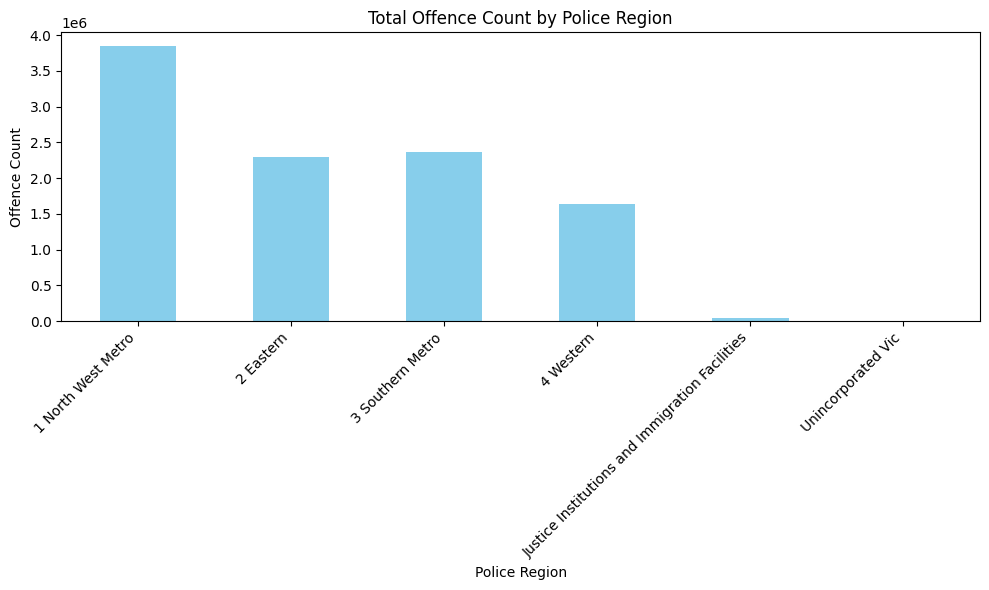

In [40]:

# Code 3
# Remove leading and trailing spaces from the 'Local Government Area' column
offenses_df["Local Government Area"] = offenses_df["Local Government Area"].str.strip()

# Verify the changes
print(offenses_df["Local Government Area"].head())

# Code 4
# 2. Bar plot for Offence Count by Police Region
plt.figure(figsize=(10, 6))
offenses_df.groupby('Police Region')['Offence Count'].sum().plot(kind='bar', color='skyblue')
plt.title('Total Offence Count by Police Region')
plt.xlabel('Police Region')
plt.ylabel('Offence Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


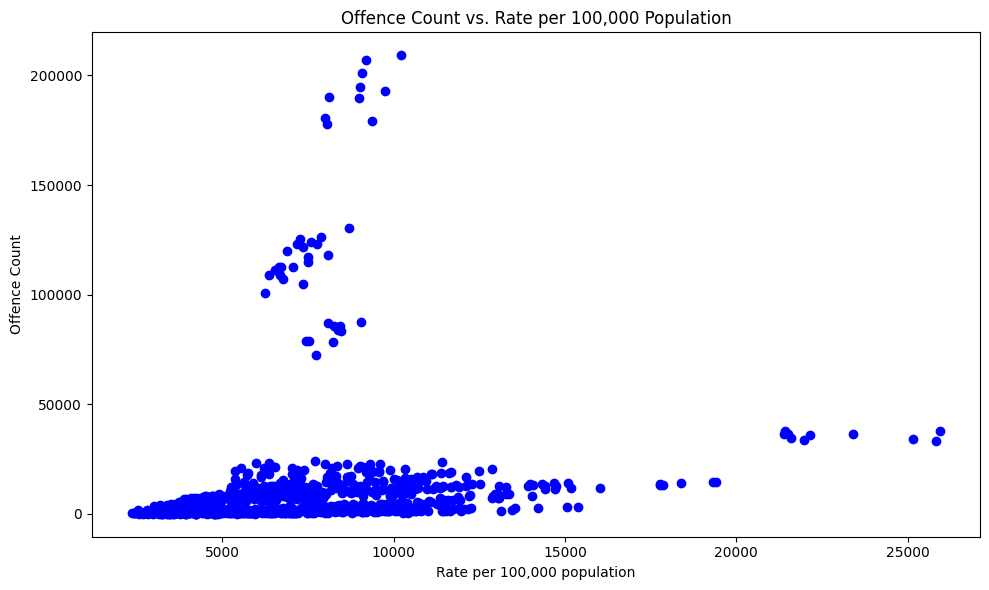

In [41]:
# 3. Scatter plot of Offence Count vs. Rate per 100,000 Population
plt.figure(figsize=(10, 6))
df_clean = offenses_df.dropna(subset=['Rate per 100,000 population'])
plt.scatter(df_clean['Rate per 100,000 population'], df_clean['Offence Count'], color='b')
plt.title('Offence Count vs. Rate per 100,000 Population')
plt.ylabel('Offence Count')
plt.xlabel('Rate per 100,000 population')
plt.tight_layout()
plt.show()


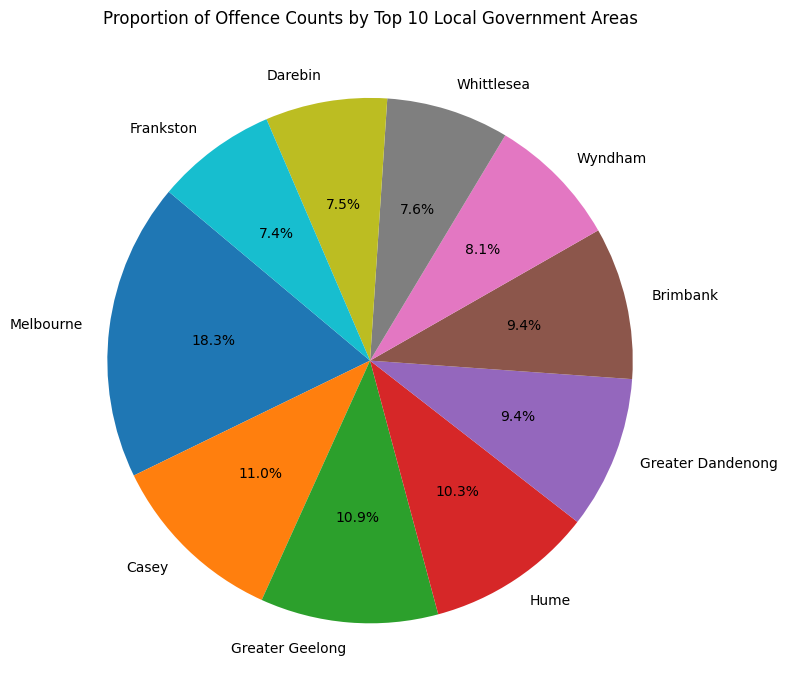

In [42]:
# Group by 'Local Government Area' and sum the 'Offence Count'
df_grouped = offenses_df.groupby('Local Government Area', as_index=False)['Offence Count'].sum()

# Filter out rows where 'Local Government Area' contains 'Total'
df_filtered = df_grouped[~df_grouped['Local Government Area'].str.contains('Total')]

# Sort the filtered DataFrame by 'Offence Count' and select the top 10 LGAs
top10_df = df_filtered.sort_values(by='Offence Count', ascending=False).head(10)

# Plot pie chart for the top 10 LGAs
plt.figure(figsize=(8, 8))
plt.pie(top10_df['Offence Count'], labels=top10_df['Local Government Area'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Offence Counts by Top 10 Local Government Areas')
plt.tight_layout()
plt.show()


In [43]:
# Merge the datasets on the LGA name (ignoring case)
merged_df = pd.merge(
    offenses_df,
    communities_df,
    left_on=offenses_df['Local Government Area'].str.lower(),
    right_on=communities_df['LGA'].str.lower(),
    how='inner'
)

In [44]:
merged_df

,key_0,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population",Community Name,Region,Map reference,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Bellfield (Suburb),C,4,...,3.599378,2.709002,512.853675,Austin Hospital,3.528298,2.671092,109.58941308,21.368554,266.84981687000004,52.032350
1,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Briar Hill (Suburb),C,2,...,13.401781,10.185617,649.298834,Austin Hospital,13.330700,10.147707,136.55978449999998,21.031885,306.90403882,47.266994
2,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Bundoora (Suburb),C,4,...,10.074500,8.430261,7241.403944,Austin Hospital,10.003419,8.392351,1442.553550979,19.920910,3479.246822911,48.046578
3,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Eaglemont (Suburb),C,4,...,1.991886,1.213006,1151.726057,Austin Hospital,1.920805,1.175096,246.10720129,21.368554,599.27012785,52.032350
4,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Greensborough (Suburb),C,2,...,12.551082,9.976777,4185.661882,Austin Hospital,12.480001,9.938867,925.701365896,22.116009,1989.3664530300002,47.528121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10675,yarriambiack,2014,December,4 Western,Yarriambiack,355,5127.094165,Warracknabeal (Catchment),S,1,...,51.470585,62.174985,443.674254,Wimmera Base Hospital,51.470585,62.174985,115.48786341,26.029877,278.71576999999996,62.819911
10676,yarriambiack,2014,December,4 Western,Yarriambiack,355,5127.094165,Warracknabeal (Town),S,1,...,47.532401,57.456008,594.918875,Wimmera Base Hospital,47.532401,57.456008,158.32162795,26.612305,372.65118554000003,62.638992
10677,yarriambiack,2014,December,4 Western,Yarriambiack,355,5127.094165,Woomelang (Town),S,1,...,127.227619,155.356958,32.698823,Wimmera Base Hospital,127.227619,155.356958,10.41823686,31.861199,21.04277543,64.353312
10678,unincorporated vic,2014,December,Unincorporated Vic,Unincorporated Vic,116,NaN,Falls Creek (Town),NaN,2,...,34.842485,30.377825,9.944488,Northeast Health Wangaratta,130.902919,138.976425,<5,NaN,7.95559002,80.000000


In [45]:
# Drop unnecessary columns and handle missing values
merged_df_clean = merged_df.dropna()


In [46]:
merged_df_clean

,key_0,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population",Community Name,Region,Map reference,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Bellfield (Suburb),C,4,...,3.599378,2.709002,512.853675,Austin Hospital,3.528298,2.671092,109.58941308,21.368554,266.84981687000004,52.032350
1,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Briar Hill (Suburb),C,2,...,13.401781,10.185617,649.298834,Austin Hospital,13.330700,10.147707,136.55978449999998,21.031885,306.90403882,47.266994
2,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Bundoora (Suburb),C,4,...,10.074500,8.430261,7241.403944,Austin Hospital,10.003419,8.392351,1442.553550979,19.920910,3479.246822911,48.046578
4,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Greensborough (Suburb),C,2,...,12.551082,9.976777,4185.661882,Austin Hospital,12.480001,9.938867,925.701365896,22.116009,1989.3664530300002,47.528121
6,banyule,2023,December,1 North West Metro,Banyule,8072,6256.318199,Heidelberg Heights (Suburb),C,4,...,3.434569,2.107103,1901.041226,Austin Hospital,3.363488,2.069194,406.22501573000005,21.368554,989.1564157800001,52.032350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10629,pyrenees,2014,December,4 Western,Pyrenees,451,6399.886477,Alfredton (Catchment),S,3,...,22.116651,20.746669,2051.046370,Ballarat Hospital,22.116651,20.746669,659.6341160030001,32.160858,1351.435011031,65.890027
10640,southern grampians,2014,December,4 Western,Southern Grampians,953,5862.811443,Hamilton (Town),S,1,...,3.299888,2.067940,4618.770556,Hamilton Base Hospital,3.299888,2.067940,1337.3675117399998,28.955054,2953.4950645400004,63.945481
10648,surf coast,2014,December,4 Western,Surf Coast,1411,4886.749325,Torquay - Jan Juc (Town),S,3,...,21.982627,21.378094,2342.536610,Geelong Hospital,21.982627,21.378094,664.56657348,28.369528,1343.6680173699997,57.359531
10656,swan hill,2014,December,4 Western,Swan Hill,2197,10491.881566,Robinvale (Town),RC,1,...,108.985735,133.759526,259.551058,Swan Hill District Hospital (Swan Hill),108.985735,133.759526,53.53968017900001,20.627803,136.75896568000002,52.690583


In [47]:

# Convert categorical columns into numeric via Label Encoding
label_encoder = LabelEncoder()
for column in merged_df_clean.select_dtypes(include=['object']).columns:
    merged_df_clean[column] = label_encoder.fit_transform(merged_df_clean[column])

merged_df_clean.head()


/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/1431907604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean[column] = label_encoder.fit_transform(merged_df_clean[column])
/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/1431907604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean[column] = label_encoder.fit_transform(merged_df_clean[column])
/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/1431907604.py:4: SettingWithCopyW

,key_0,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population",Community Name,Region,Map reference,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,2,2023,0,0,2,8072,6256.318199,44,0,4,...,3.599378,2.709002,512.853675,1,3.528298,2.671092,19,21.368554,176,52.032350
1,2,2023,0,0,2,8072,6256.318199,61,0,2,...,13.401781,10.185617,649.298834,1,13.330700,10.147707,52,21.031885,202,47.266994
2,2,2023,0,0,2,8072,6256.318199,68,0,4,...,10.074500,8.430261,7241.403944,1,10.003419,8.392351,63,19.920910,213,48.046578
4,2,2023,0,0,2,8072,6256.318199,164,0,2,...,12.551082,9.976777,4185.661882,1,12.480001,9.938867,383,22.116009,130,47.528121
6,2,2023,0,0,2,8072,6256.318199,182,0,4,...,3.434569,2.107103,1901.041226,1,3.363488,2.069194,223,21.368554,388,52.032350


In [48]:
# Normalize numeric columns for better clustering
scaler = StandardScaler()
numerical_cols = merged_df_clean.select_dtypes(include=[np.number]).columns
merged_df_clean[numerical_cols] = scaler.fit_transform(merged_df_clean[numerical_cols])


/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/2517428679.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean[numerical_cols] = scaler.fit_transform(merged_df_clean[numerical_cols])


In [49]:
merged_df_clean

,key_0,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population",Community Name,Region,Map reference,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,-1.412181,1.566699,0.0,-1.170372,-1.412181,-0.548677,-0.511465,-1.338809,-0.478606,1.030259,...,-0.644095,-0.591985,-0.919772,-1.589786,-0.632820,-0.578149,-1.548917,-0.720498,-0.164899,-0.389420
1,-1.412181,1.566699,0.0,-1.170372,-1.412181,-0.548677,-0.511465,-1.188580,-0.478606,-0.659538,...,0.243317,0.026796,-0.869966,-1.589786,0.027997,-0.149662,-1.256405,-0.803895,0.066500,-1.018014
2,-1.412181,1.566699,0.0,-1.170372,-1.412181,-0.548677,-0.511465,-1.126720,-0.478606,1.030259,...,-0.057902,-0.118481,1.536327,-1.589786,-0.196307,-0.250262,-1.158901,-1.079095,0.164400,-0.915180
4,-1.412181,1.566699,0.0,-1.170372,-1.412181,-0.548677,-0.511465,-0.278366,-0.478606,-0.659538,...,0.166303,0.009512,0.420900,-1.589786,-0.029352,-0.161631,1.677581,-0.535346,-0.574298,-0.983569
6,-1.412181,1.566699,0.0,-1.170372,-1.412181,-0.548677,-0.511465,-0.119300,-0.478606,1.030259,...,-0.659015,-0.641799,-0.413047,-1.589786,-0.643931,-0.612644,0.259340,-0.720498,1.721896,-0.389420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10629,1.177307,-1.566699,0.0,1.507367,1.177307,-1.675605,-0.468673,-1.656942,2.163837,0.185360,...,1.032275,0.900851,-0.358291,-1.344094,0.620292,0.457767,1.039372,1.952865,-1.277396,1.438534
10640,1.292395,-1.566699,0.0,1.507367,1.292395,-1.601374,-0.628752,-0.225344,2.163837,-1.504436,...,-0.671208,-0.645040,0.578996,-0.115638,-0.648218,-0.612716,-1.282997,1.158755,0.004200,1.182030
10648,1.407484,-1.566699,0.0,1.507367,1.407484,-1.533649,-0.919674,1.382994,2.163837,0.185360,...,1.020142,0.953109,-0.251889,-0.238484,0.611257,0.493954,1.074828,1.013714,-1.286296,0.313283
10656,1.465028,-1.566699,0.0,1.507367,1.465028,-1.417422,0.750974,0.870447,0.842616,-1.504436,...,8.896542,10.254035,-1.012234,1.358510,6.476469,6.934560,0.720268,-0.903990,-1.259596,-0.302593


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split data into features (X) and target (y)
X = merged_df_clean.drop(columns=['Offence Count'])
y = merged_df_clean['Offence Count']  # Predicting offence counts

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


Mean Squared Error: 0.0009733340233261075
R^2 Score: 0.9990988685519715


/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/2566871489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df_clean['Cluster'] = clusters
/var/folders/0r/8fjz8qv930d4x2np363qjwpm0000gn/T/ipykernel_31894/2566871489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['Cluster'] = clusters


Silhouette Score: 0.09067653349309997


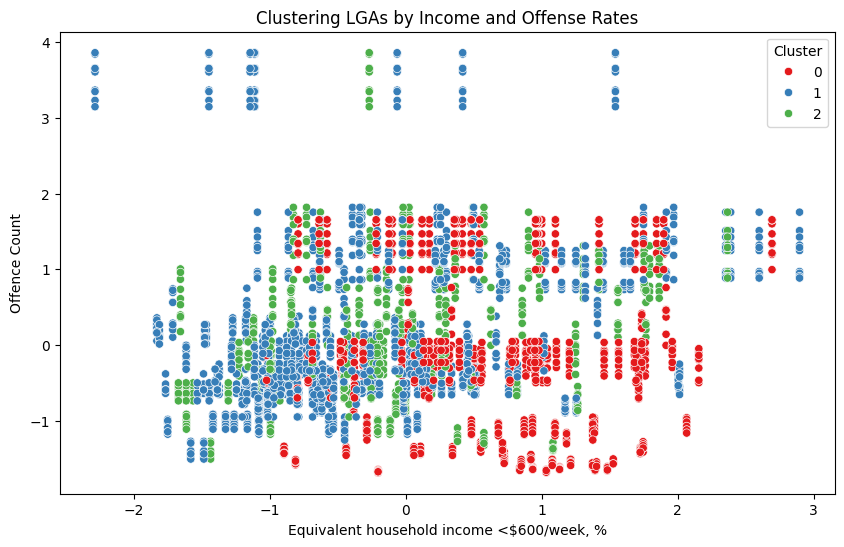

In [51]:
# Use KMeans to group regions based on crime trends
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataset
merged_df_clean['Cluster'] = clusters

# Evaluate clustering performance using Silhouette Score
silhouette_avg = silhouette_score(X, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df_clean['Equivalent household income <$600/week, %'], 
                y=merged_df_clean['Offence Count'], 
                hue=merged_df_clean['Cluster'], 
                palette='Set1')
plt.title('Clustering LGAs by Income and Offense Rates')
plt.show()
